# KTRLite Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

In [3]:
print(orbit.__version__)
print(matplotlib.__version__)

1.0.16dev
3.3.4


## Data

In [4]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

df[RESPONSE_COL] = np.log(df[RESPONSE_COL])

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

In [6]:
test_size=365

train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [7]:
ktrlite = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    seasonality_segments=2,
    estimator='stan-map',
    n_bootstrap_draws=1e4,
)

In [8]:
ktrlite.fit(train_df)

In [9]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365.25_5,seasonality_365.25,seasonality_365.25_95
0,2008-01-02,9.94454,10.01190,10.07996,10.00885,10.01038,10.01187,0.02593,0.02593,0.02593,-0.02441,-0.02441,-0.02441
1,2008-01-03,9.94778,10.01404,10.08101,10.00732,10.01038,10.01336,0.02841,0.02841,0.02841,-0.02475,-0.02475,-0.02475
2,2008-01-04,9.96004,10.02831,10.09600,10.00578,10.01038,10.01484,0.04281,0.04281,0.04281,-0.02488,-0.02488,-0.02488
3,2008-01-05,9.88605,9.95419,10.02184,10.00425,10.01038,10.01633,-0.03141,-0.03141,-0.03141,-0.02478,-0.02478,-0.02478
4,2008-01-06,9.82753,9.89573,9.96408,10.00272,10.01038,10.01782,-0.09020,-0.09020,-0.09020,-0.02446,-0.02446,-0.02446


In [10]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df['electricity'].values):.2%}"

'SMAPE: 0.44%'

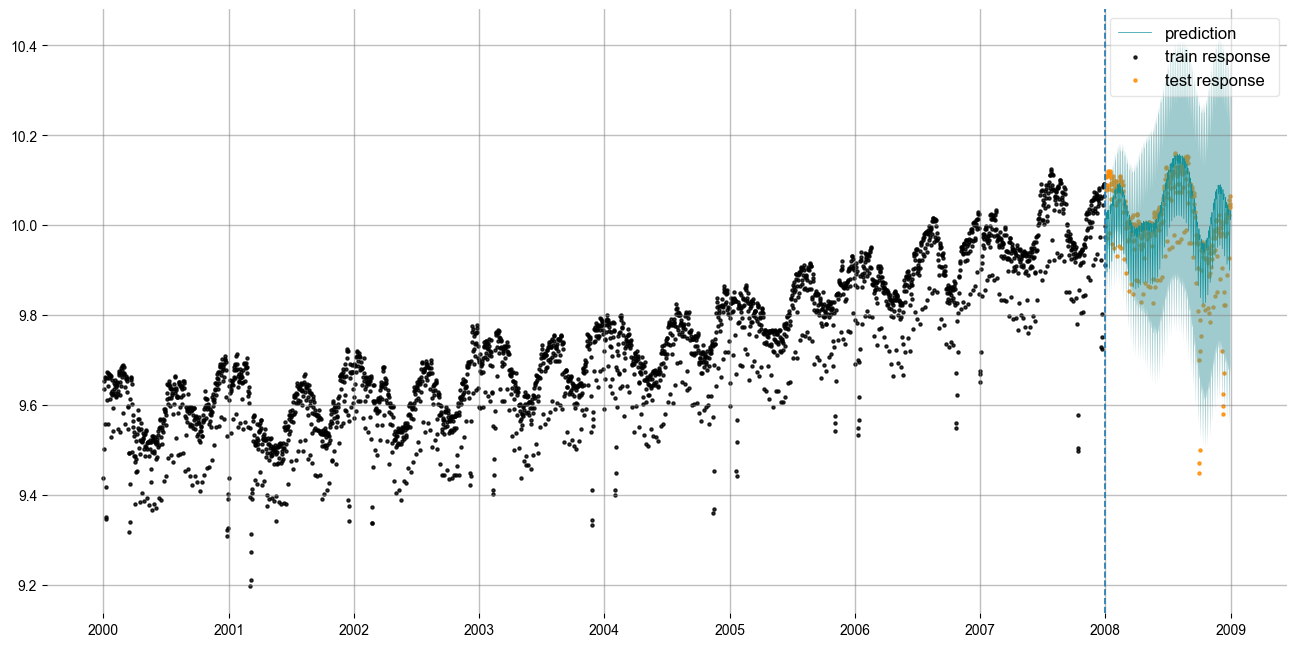

In [11]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL, 
                        test_actual_df=test_df,
                        markersize=20, lw=.5)

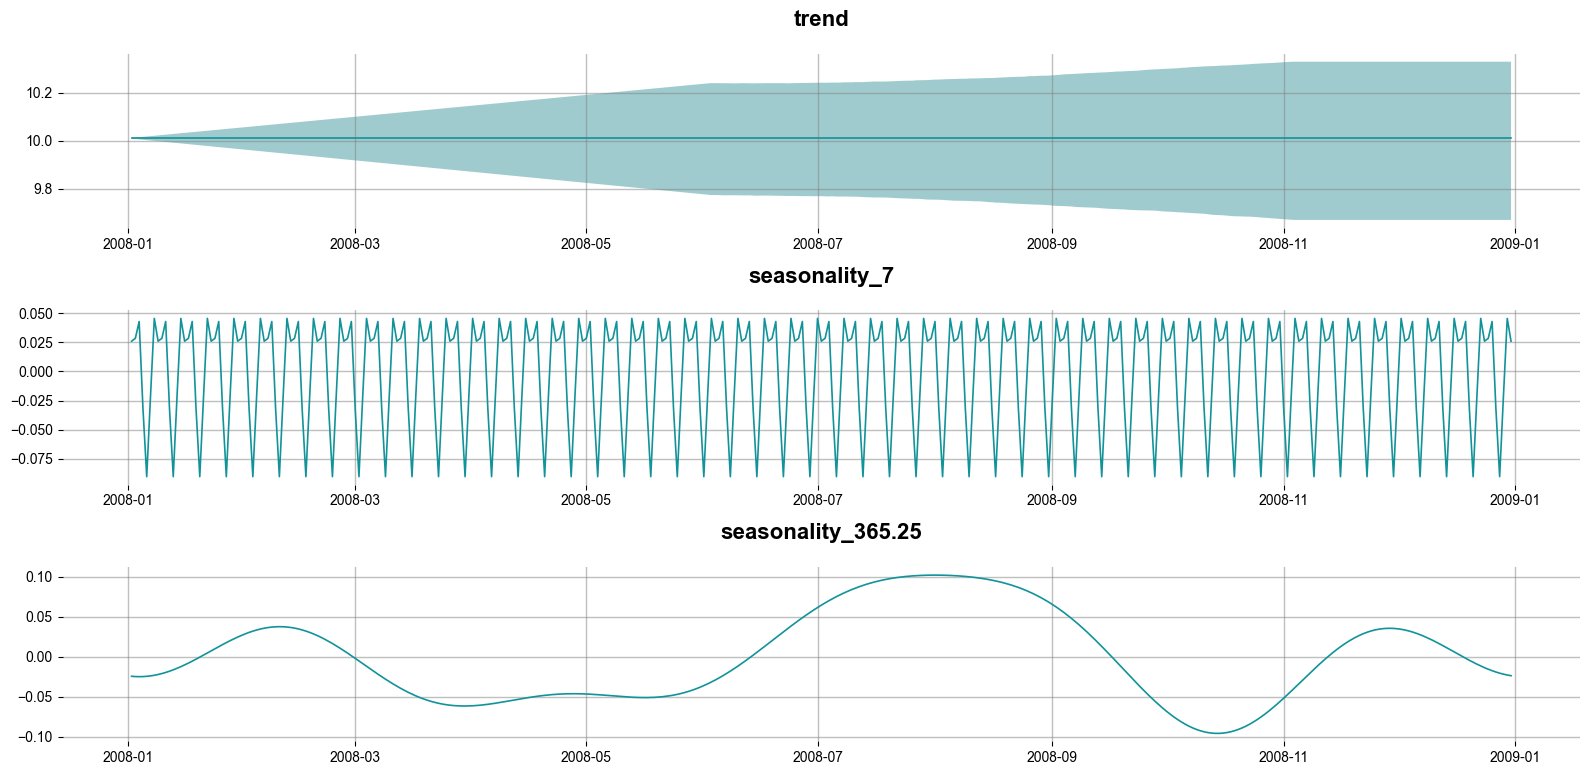

In [12]:
_ = plot_predicted_components(predicted_df=predicted_df,
                              date_col=DATE_COL, 
                              plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

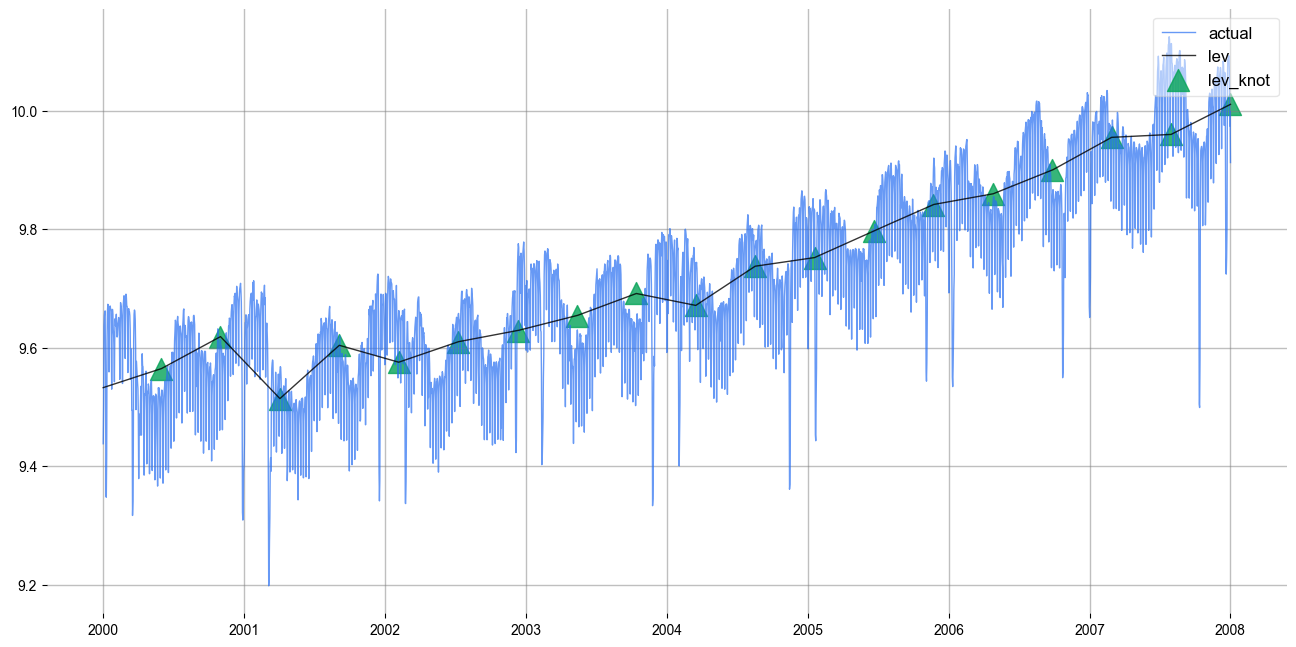

In [13]:
_ = ktrlite.plot_lev_knots()

In [14]:
ktrlite._model._level_knot_dates

array(['1999-12-28T00:00:00.000000000', '2000-05-30T00:00:00.000000000',
       '2000-10-31T00:00:00.000000000', '2001-04-03T00:00:00.000000000',
       '2001-09-04T00:00:00.000000000', '2002-02-05T00:00:00.000000000',
       '2002-07-09T00:00:00.000000000', '2002-12-10T00:00:00.000000000',
       '2003-05-13T00:00:00.000000000', '2003-10-14T00:00:00.000000000',
       '2004-03-16T00:00:00.000000000', '2004-08-17T00:00:00.000000000',
       '2005-01-18T00:00:00.000000000', '2005-06-21T00:00:00.000000000',
       '2005-11-22T00:00:00.000000000', '2006-04-25T00:00:00.000000000',
       '2006-09-26T00:00:00.000000000', '2007-02-27T00:00:00.000000000',
       '2007-07-31T00:00:00.000000000', '2008-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [15]:
lev_knots_df = ktrlite.get_level_knots()
lev_knots_df.head()

,date,lev_knot
0,1999-12-28,9.53144
1,2000-05-30,9.56407
2,2000-10-31,9.61838
3,2001-04-03,9.51377
4,2001-09-04,9.60374


# Stability Check

In [16]:
ktrlite1 = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    seasonality_segments=2,
    estimator='stan-map',
    seed=2020
)


ktrlite2 = KTRLite(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    seasonality_segments=2,
    estimator='stan-map',
    seed=2021
)

ktrlite1.fit(df)
ktrlite2.fit(df)

In [17]:
np.allclose(
    ktrlite1.get_point_posteriors()['map']['lev_knot'],
    ktrlite2.get_point_posteriors()['map']['lev_knot'],
    rtol=1e-3,
)

True

In [18]:
from orbit.utils.simulation import make_trend, make_seasonality, make_regression
import pandas as pd
import numpy as np

n_obs = 365 * 3
seed = 2020
rw = make_trend(n_obs, rw_loc=0.02, rw_scale=0.1, seed=seed)
fs = make_seasonality(n_obs, seasonality=365, method='fourier', order=5, seed=seed)
coef = [0.2, 0.1, 0.3]
x, y, coef = make_regression(n_obs, coef, scale=2.0, seed=seed)

df = pd.DataFrame(np.concatenate([(rw + fs + y).reshape(-1, 1), x], axis=1), columns=['response'] + list('abc'))
df['date'] = pd.date_range(start='2016-01-01', periods=n_obs)
train_df = df[df['date'] < '2018-01-01']
test_df = df[df['date'] >= '2018-01-01']


In [19]:
ktrlite = KTRLite(
    response_col='response',
    date_col='date',
    seasonality=[365.25],
    seasonality_fs_order=[5],
    estimator='stan-map',
)

In [20]:
ktrlite.fit(train_df)